# Импорт необходимых библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install pytorch-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [ ]:
! pip install pymorphy3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 29.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import torch

import string
import re

from tqdm import tqdm, trange, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

import random
import pymorphy3

import matplotlib.pyplot as plt
%matplotlib inline


ModuleNotFoundError: No module named 'pymorphy3'

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification, WarmupLinearSchedule
from tqdm import tqdm, trange, tqdm_notebook
import io
from IPython.display import clear_output

In [ ]:
import os

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from collections import Counter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [3]:
dataset = pd.read_excel('/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/cleaned data Guilford.xlsx')

dataset.head(5)

,Unnamed: 0,ID,attempt,n,answer,origNew,prepr_text,simple_category
0,0,PTxGzRMvLY,1,1,сложить из спичек домик,3,сложить из спичек домик,5
1,1,PTxGzRMvLY,1,2,использовать спички как опору чего - нибудь,5,использовать спички как опору чего нибудь,6
2,2,PTxGzRMvLY,1,3,спичками мжно ковыряться в зубах,3,спичками мжно ковыряться в зубах,6
3,3,PTxGzRMvLY,1,4,"если сложить спички в виде колодца, можно испо...",5,если сложить спички в виде колодца можно испол...,6
4,4,PTxGzRMvLY,1,5,"если разукрасить спички, то можно сложить их н...",2,если разукрасить спички то можно сложить их на...,5


Сразу смотрим, сколько примеров на каждый балл оригинальности:

In [ ]:
dataset['simple_category'].value_counts(ascending=True)

simple_category
9       2
8       5
3      29
4      95
2     370
1     889
7    1164
5    1768
6    3034
Name: count, dtype: int64

# Зафиксируем seed для воспроизводимости

In [ ]:
#фиксируем seed
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

RANDOM_SEED = 1500

init_random_seed(value=RANDOM_SEED)

# Fine-tuning BERT

In [ ]:
# переопределим их от 0 до 8

#Так я пыталась решить ошибку, которая появлялась на этапе обучения модели
#RuntimeError: CUDA error: device-side assert triggered

# UPD: исключим слишком маленькие категории

def get_classes():
  classes = []
  for value in dataset.simple_category:
    if value in [9, 8, 2, 3, 4]:
      cls = 98234
    elif value < 2:
      cls = int(value-1)
    else:
      cls = int(value-4)
    classes.append(cls)

  dataset.simple_category = classes
  dataset.simple_category.unique()

In [ ]:
# !!! 9 КЛАССОВ
classes = [int(x)-1 for x in dataset.simple_category.values]

dataset.simple_category = classes

In [ ]:
# !!! 4 КЛАССА

#get_classes()
#dataset = dataset.drop(dataset[(dataset.simple_category == 98234)].index)
#dataset.shape

In [ ]:
dataset['simple_category'].value_counts()

simple_category
5    3034
4    1768
6    1164
0     889
1     370
3      95
2      29
7       5
8       2
Name: count, dtype: int64

In [ ]:
type(dataset.simple_category[0])

numpy.int64

In [ ]:
# целочисленные баллы оригинальности превращаются в лейблы классов
labels = dataset.simple_category

In [ ]:
sentences_bert = ["[CLS] " + sentence + " [SEP]" for sentence in dataset['eng_text'].values]

In [ ]:
train_sentences, test_sentences, train_y, test_y = train_test_split(sentences_bert,
                                                                    labels, test_size=0.2, stratify=labels, random_state=RANDOM_SEED)

In [ ]:
from pytorch_transformers import BertTokenizer, BertConfig

# здесь меняем max_len
# 85 получилось оптимально

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# base -model | uncased - все слова в нижнем регистре
tokenized_texts_train = [tokenizer.tokenize(sent[:85]) for sent in train_sentences]
tokenized_texts_test = [tokenizer.tokenize(sent[:85]) for sent in test_sentences]
print(tokenized_texts_train[0])

100%|██████████| 231508/231508 [00:00<00:00, 910652.34B/s]


['[CLS]', 'if', 'you', 'cut', 'the', 'br', '##ine', 'from', 'the', 'tip', 'of', 'the', 'match', ',', 'it', "'", 's', 'bitter', '[SEP]']


In [ ]:
sum([1 for sent in train_sentences if len(sent) > 70])

715

In [ ]:
len(tokenized_texts_train)

5884

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids = pad_sequences(
    input_ids,
    maxlen=128,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
sum([len(text) for text in tokenized_texts_train])/len(tokenized_texts_train)

9.57121006118287

In [ ]:
train_inputs = input_ids
train_labels = train_y
train_masks = attention_masks

val_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
val_input_ids = pad_sequences(
    val_input_ids,
    maxlen=128,
    dtype="long",
    truncating="post",
    padding="post"
)
val_attention_masks = [[float(i>0) for i in seq] for seq in val_input_ids]

validation_inputs = val_input_ids
validation_labels = test_y
validation_masks = val_attention_masks

In [ ]:
train_inputs.shape

(5884, 128)

In [ ]:
train_labels.shape

(5884,)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = np.array(train_labels)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = np.array(validation_labels)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels.shape, validation_labels.shape

(torch.Size([5884]), torch.Size([1472]))

Можно попробовать разные batch_size: 8, 16, 32

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size= 32
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size= 32
)

# Обучение модели Bert For Sequence Classification:

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

100%|██████████| 440473133/440473133 [00:15<00:00, 28845493.92B/s]


In [ ]:
model = model.to(device)

#RuntimeError: CUDA error: device-side assert triggered
#CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
#For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
#Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions

In [ ]:
epochs = 10

optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

lmbda = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

max_grad_norm_clipping = 1

In [ ]:
len(train_dataloader)

184

In [ ]:
def train(model, train_dataloader, optimizer, EPOCH_AMOUNT, with_clipping=False,max_grad_norm_clipping=1):
    # Будем сохранять loss во время обучения
    # и рисовать график в режиме реального времени
    train_loss_set = []
    train_loss = 0


    # Обучение
    # Переводим модель в training mode
    model.train()

    for _ in range(EPOCH_AMOUNT):
        for step, batch in enumerate(train_dataloader):
            # добавляем батч для вычисления на GPU
            batch = tuple(t.to(device) for t in batch)

            # Распаковываем данные из dataloader
            b_input_ids, b_input_mask, b_labels = batch

            # если не сделать .zero_grad(), градиенты будут накапливаться
            optimizer.zero_grad()

            # Forward pass
            loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            if len(train_loss_set) > 0:
              if loss[0].item() < min(train_loss_set):
                print(round(loss[0].item(),3))
                print(min(train_loss_set))

                # чтобы хранилища google хватало, предыдущике файлы будем сразу удалять
                f = '/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/engBRT_cat_9_'+str(round(min(train_loss_set),3))+'.ckpt'
                #f = '/content/drive/MyDrive/Лорочкина папочка/BRT_cat_'+str(round(min(train_loss_set),3))+'.ckpt'
                if os.path.isfile(f):
                  os.remove(f)

                torch.save(model.state_dict(),
                           '/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/engBRT_cat_9_' + str(round(loss[0].item(),3))+'.ckpt')
                #torch.save(model.state_dict(),
                           #'/content/drive/MyDrive/Лорочкина папочка/BRT_cat_' + str(round(loss[0].item(),3)) + '.ckpt')
            train_loss_set.append(loss[0].item())

            # Backward pass
            loss[0].backward()

            if with_clipping:
                # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm_clipping)

            # Обновляем параметры и делаем шаг используя посчитанные градиенты
            optimizer.step()
            #scheduler.step()

            # Обновляем loss
            train_loss += loss[0].item()

            # Рисуем график
            clear_output(True)
            plt.figure(figsize=(12, 6))
            plt.plot(train_loss_set)
            plt.title("Training loss")
            plt.xlabel("Batch")
            plt.ylabel("Loss")
            plt.grid()
            plt.show()

        print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))
        print(min(train_loss_set))

In [ ]:
def test(model, dataloader, name_dtlder='Test'):
    # Валидация
    # Переводим модель в evaluation mode
    model.eval()
    test_preds, test_labels = [], []

    n = 0

    model_name = input('как сохранить результаты валидации?')
    f = '/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/'+model_name+'val_acc_scrore.txt'
    #f = '/content/drive/MyDrive/Лорочкина папочка/'+model_name+'val_acc_scrore.txt'

    with open(f, 'w', encoding='utf-8') as rec:

      for batch in tqdm_notebook(dataloader):
          # добавляем батч для вычисления на GPU
          batch = tuple(t.to(device) for t in batch)

          # Распаковываем данные из dataloader
          b_input_ids, b_input_mask, b_labels = batch

          # При использовании .no_grad() модель не будет считать и хранить градиенты.
          # Это ускорит процесс предсказания меток для тестовых данных.
          with torch.no_grad():
              logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

          # Перемещаем logits и метки классов на CPU для дальнейшей работы
          logits = logits[0].detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Сохраняем предсказанные классы и ground truth
          batch_preds = np.argmax(logits, axis=1)

          if len(label_ids.shape) == 1:
              batch_labels = label_ids
          else:
              batch_labels = np.concatenate(label_ids)
          test_preds.extend(batch_preds)
          test_labels.extend(batch_labels)
          batch_preds = np.argmax(logits, axis=1)

          print(n, ' val accuracy score: ', accuracy_score(test_labels, test_preds))
          rec.write(str(n)+' val accuracy score: '+str(accuracy_score(test_labels, test_preds))+'\n')

          n += 1

      acc_score = accuracy_score(test_labels, test_preds)
      print('Процент правильных предсказаний на {0} выборке составил:  f1 = {1:.2f}%'.format(name_dtlder,
                                                                                             f1_score(test_labels,
                                                                                                      test_preds,
                                                                                                      average='macro') * 100))
      rec.write('Процент правильных предсказаний на {0} выборке составил:  f1 = {1:.2f}%'.format(name_dtlder,
                                                                                             f1_score(test_labels,
                                                                                                      test_preds,
                                                                                                      average='macro') * 100))
      rec.close()

    return test_preds, test_labels

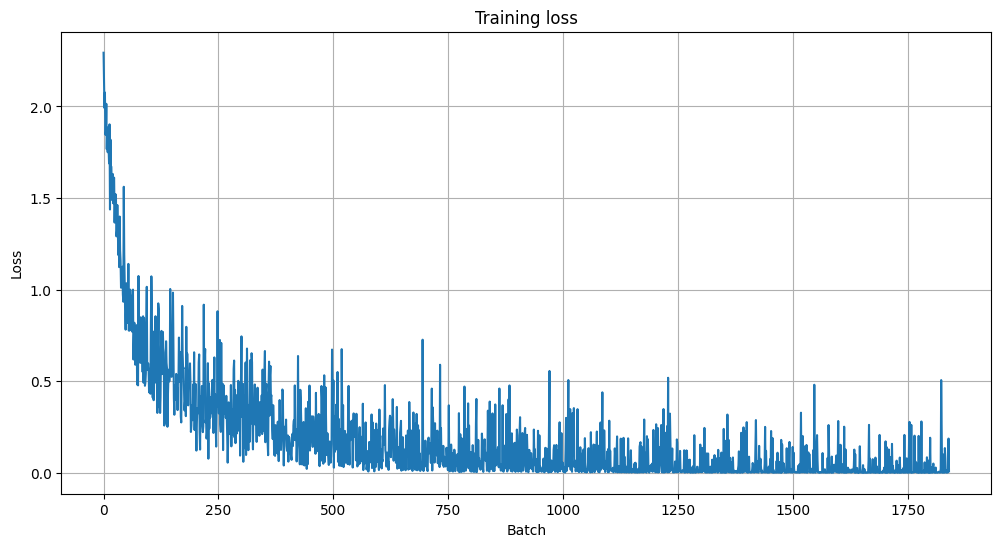

Loss на обучающей выборке: 1.91911
0.0004889908595941961


In [ ]:
train(model, train_dataloader, optimizer, epochs, with_clipping=1)

#RuntimeError: CUDA error: device-side assert triggered
#CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
#For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
#Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions

# Валидация:

In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/Лорочкина папочка/engBRT_cat_9_0.0.ckpt'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Гилфорд Маг Диплом Розовская/New results/engBRT_cat_9_0.0.ckpt'))

# если вдруг не на gpu
#model.load_state_dict(torch.load('/content/drive/MyDrive/Лорочкина папочка/Bert_model/BRT_0.007_31мар17.43.ckpt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
val_preds, val_labels = test(model, validation_dataloader, name_dtlder='VAl')

как сохранить результаты валидации?engBRT_cat_9_0.0


  0%|          | 0/46 [00:00<?, ?it/s]

0  val accuracy score:  0.78125
1  val accuracy score:  0.84375
2  val accuracy score:  0.84375
3  val accuracy score:  0.84375
4  val accuracy score:  0.84375
5  val accuracy score:  0.8385416666666666
6  val accuracy score:  0.8526785714285714
7  val accuracy score:  0.84765625
8  val accuracy score:  0.8506944444444444
9  val accuracy score:  0.84375
10  val accuracy score:  0.8494318181818182
11  val accuracy score:  0.8385416666666666
12  val accuracy score:  0.84375
13  val accuracy score:  0.8504464285714286
14  val accuracy score:  0.8541666666666666
15  val accuracy score:  0.86328125
16  val accuracy score:  0.8584558823529411
17  val accuracy score:  0.8541666666666666
18  val accuracy score:  0.8536184210526315
19  val accuracy score:  0.8546875
20  val accuracy score:  0.8571428571428571
21  val accuracy score:  0.8579545454545454
22  val accuracy score:  0.8546195652173914
23  val accuracy score:  0.8515625
24  val accuracy score:  0.8525
25  val accuracy score:  0.854567

In [ ]:
target_names = [str(c) for c in dataset.simple_category.unique()]
target_names = set(target_names)
target_names

{'0', '1', '2', '3'}

In [ ]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       178
           1       0.78      0.54      0.64        74
           2       0.67      0.33      0.44         6
           3       0.74      0.89      0.81        19
           4       0.85      0.82      0.84       354
           5       0.84      0.92      0.88       607
           6       0.88      0.78      0.83       233
           7       1.00      1.00      1.00         1

    accuracy                           0.85      1472
   macro avg       0.83      0.77      0.79      1472
weighted avg       0.85      0.85      0.84      1472



In [ ]:
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

In [ ]:
val_preds[:100]

array([2, 1, 1, 0, 1, 1, 3, 2, 2, 2, 3, 1, 1, 2, 3, 2, 3, 2, 2, 0, 1, 1,
       1, 1, 2, 1, 0, 2, 3, 1, 2, 2, 1, 2, 1, 2, 3, 3, 0, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 2, 1, 1, 3, 3, 1, 2, 1, 3, 1, 0, 1, 0, 2, 3, 2, 1, 2,
       2, 2, 1, 1, 0, 2, 0, 3, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 1,
       1, 1, 2, 2, 1, 2, 2, 2, 0, 3, 3, 2])

In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(val_labels != val_preds),
    len(val_labels)
))

Неправильных предсказаний: 190/1371


BERT токенизирует слова с помощью BPE и часть важной информации, которая помогает трансформеру хорошо повысить качество, не отбрасывается во время препроцессинга (как было в предыдущих моделях). Также эмбеддинги BERTа не только учитывают локальную близость, но и контекст в котором слово подразумевается.